In [23]:
import numpy as np
import pandas as pd
import spacy
import glob 
import pyLDAvis
import pyLDAvis.sklearn
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm import tqdm
import matplotlib.pyplot as plt
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from spacy.lang.nl.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest
from spacy.lang.nl import Dutch

In [24]:
def loadLangModel(lang):
    """
    This function loads a spacy model and return it.
    """
    return spacy.load(lang)

In [25]:
# load a medium sized dutch language model in spacy
#nlp = loadLangModel('nl_core_news_md')
nlp = loadLangModel('nl_core_news_lg')

#### Functions for word frequencie, percentage importance, entities visualization, POS and summarization of text

In [26]:
stop_words = ['ambivalentie','besluit', 'koninklijk', 'brussel', 'brussels', 'hoofdstedelijk', 'gewest', 'wet', 'regering', 'vlaams', 'vlaamse', 'waals', 'waalse', 'nota', 'gemeenschap', 'bevoegd', 'bevoegde', 'artikel']
    
for i in list(STOP_WORDS):
        stop_words.append(str(i))

In [27]:
#Using spaCy's built-in visualizer to detect named entities in the document
def visualizeEntities(doc):
    """
    This function uses displacy from spaCy to show named entities of a document
    """
    displacy.render(doc, style="ent", jupyter=True)
    

In [28]:
#Calculating word frequencies from the text after removing stopwords and puntuactions:
def displayWordFrequencies(doc, stopwords):
    """
    this function returns word frequenties and should be given a doc and the stopwords corresponding to the imported language
    in spacy
    For example in Dutch:
    from spacy.lang.nl.stop_words import STOP_WORDS
    """
    #First lemmatize the doc
    doc = str(" ".join([i.lemma_ for i in doc]))
    doc = nlp(doc)
    word_frequencies={}
    for word in doc:
        if word.text.lower() not in stopwords:
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1
    return word_frequencies

In [29]:
#Calculate the maximum frequency and divide it by all frequencies to get normalized word frequencies.
def percentageImportance(word_frequencies):
    """
    This function returns the word importance percentage, we must pass word frequencie first 
    """
    max_frequency=max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word]=(word_frequencies[word]/max_frequency)
    
    
    return word_frequencies

In [30]:
#Ref for attempting summarization https://www.numpyninja.com/post/text-summarization-through-use-of-spacy-library
def createSummary(doc, word_frequencies):
    """
    this function creates a summary of the given text
    """
    #Get sentence tokens 
    sentence_tokens= [sent for sent in doc.sents]
    #Calculate the most important sentences by adding the word frequencies in each sentence.
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():                            
                 sentence_scores[sent]=word_frequencies[word.text.lower()]
                else:
                 sentence_scores[sent]+=word_frequencies[word.text.lower()]
    
    #From headhq import nlargest and calculate  30% of text with maximum score.
    select_length=int(len(sentence_tokens)*0.3)
    select_length
    summary=nlargest(select_length, sentence_scores,key=sentence_scores.get)
    summary
    #Get the final summary of text
    final_summary=[word.text for word in summary]
    final_summary
    summary=''.join(final_summary)
    
    return summary
                


In [31]:
def showPOS(doc):
    """
    This function shows parts of speech tagging for a text
    """
    
    for i in nlp(doc):
        print(i, "=>", i.pos_)

### Creating a dataframe from files

In [32]:
#all the texts together
def createDF(path):
    """
    This function receives a path where files and merge the files into a dataframe
    
    """

    path = path
    dataframes = []
    df = pd.DataFrame(columns = ["article_content"])

    for file in glob.glob(path):
        with open(file, encoding='utf-8', errors='ignore') as file_in:
            dataframe = file_in.read().replace('\n', '')
            dataframes.append(dataframe)
    to_append = dataframes
    my_series = pd.Series(to_append)
    df["article_content"]= my_series
    
    return df


In [33]:
#df = createDF('clean_text_nl/*.txt')
df = pd.read_csv('dataframe.csv')

In [34]:
df.head()

,Unnamed: 0,url,content
0,0,http://www.ejustice.just.fgov.be/cgi/article_b...,dienst reglementering akkoord onderling overle...
1,1,http://www.ejustice.just.fgov.be/cgi/article_b...,houdende fiscaal fraudebestrijdend financieel ...
2,2,http://www.ejustice.just.fgov.be/cgi/article_b...,houdende bekrachtiging bijzonder macht nemen k...
3,3,http://www.ejustice.just.fgov.be/cgi/article_b...,dienst reglementering akkoord onderling overle...
4,4,http://www.ejustice.just.fgov.be/cgi/article_b...,bijzonder machtenbesluit steun vergoeding expl...


In [35]:
#ref: https://stackoverflow.com/questions/45605946/how-to-do-text-pre-processing-using-spacy
stopwords = list(STOP_WORDS)
punctuations = punctuation
def normalize(comment, lowercase, remove_stopwords):
    """
    This function is used to normalize the text, lemmatize, remove stopwords and punctuations
    
    """
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        #Lemmatize the word
        lemma = word.lemma_.strip()
        if lemma:
            #Remove stopwords and punctuactions
            if not remove_stopwords or (remove_stopwords and lemma not in stopwords and lemma not in punctuations):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

#### Creating a column processed content with normalized article text

#tqdm.pandas()
#df["processed_content"] = df["article_content"].progress_apply(normalize, lowercase=True, remove_stopwords=True)

In [36]:
df.head()

,Unnamed: 0,url,content
0,0,http://www.ejustice.just.fgov.be/cgi/article_b...,dienst reglementering akkoord onderling overle...
1,1,http://www.ejustice.just.fgov.be/cgi/article_b...,houdende fiscaal fraudebestrijdend financieel ...
2,2,http://www.ejustice.just.fgov.be/cgi/article_b...,houdende bekrachtiging bijzonder macht nemen k...
3,3,http://www.ejustice.just.fgov.be/cgi/article_b...,dienst reglementering akkoord onderling overle...
4,4,http://www.ejustice.just.fgov.be/cgi/article_b...,bijzonder machtenbesluit steun vergoeding expl...


In [37]:
df.drop(['Unnamed: 0', 'url'], axis=1, inplace=True)

In [38]:
df

,content
0,dienst reglementering akkoord onderling overle...
1,houdende fiscaal fraudebestrijdend financieel ...
2,houdende bekrachtiging bijzonder macht nemen k...
3,dienst reglementering akkoord onderling overle...
4,bijzonder machtenbesluit steun vergoeding expl...
...,...
660,houdende instemming samenwerkingsakkoord feder...
661,houdende divers dringend fiscaal bepaling gevo...
662,selectienummer ang solliciteren selor detaille...
663,wijziging regeling algemeen selectief subsidie...


In [39]:
#Example using one processed article in the dataframe. Here we can modify to explore result on other articles
#doc = nlp(df["processed_content"][7])
doc = nlp(df["content"][7])

#### Parts of Speech tagging of one article content

In [40]:
showPOS(doc)

wijziging => NOUN
houdende => VERB
toekenning => NOUN
ouderschapsuitkering => NOUN
gunst => NOUN
zelfstandig => ADJ
zelfstandig => ADJ
activiteit => NOUN
gedeeltelijk => ADJ
onderbreekken => VERB
kader => NOUN
maatregel => NOUN
verspreiding => NOUN
coronavirus => NOUN
covid => VERB
groet => NOUN
letten => VERB
houdende => VERB
inrichting => NOUN
sociaal => ADJ
statuut => NOUN
zelfstandig => ADJ
Bis => PROPN
§ => NOUN
invoegen => VERB
letten => VERB
advies => NOUN
algemeen => ADJ
Beheerscomité => PROPN
sociaal => ADJ
statuut => NOUN
zelfstandig => ADJ
juin => NOUN
letten => VERB
advies => NOUN
inspecteur => NOUN
financiën => NOUN
letten => VERB
akkoordbevinding => NOUN
begroting => NOUN
letten => VERB
houdende => VERB
divers => ADJ
bepaling => NOUN
administratief => ADJ
vereenvoudiging => NOUN
vrijstellen => VERB
regelgevingsimpactanalyse => NOUN
zien => VERB
hoogdringendheid => NOUN
motiveren => VERB
covid => VERB
pandemie => NOUN
letten => VERB
hoogdringendheid => NOUN
motiveren => VE

#### Showing Word frequencie with preprocessed text files in dataframe

In [41]:
#Print and see word frequencies to know important words, displaying sorted
word_frequencies = displayWordFrequencies(doc, stopwords)
w_sorted_keys = sorted(word_frequencies, key=word_frequencies.get, reverse=True)
for w in w_sorted_keys:
    print(w, word_frequencies[w])

zelfstandig 16
maatregel 10
letten 8
activiteit 7
cov_id 7
coronavirus 5
sociaal 5
kind 5
ouderschapsuitkering 4
gunst 4
verspreiding 4
advies 4
oud 4
toekenning 3
gedeeltelijk 3
onderb_reekok 3
kader 3
houdende 3
motiveren 3
raad 3
bepalen 3
tijdelijk 3
maand 3
uitkering 3
statuut 2
hoogdringendheid 2
pandemie 2
dringend 2
heropstarten 2
heropstart 2
combinatie 2
school 2
werk 2
kindopvang 2
geval 2
jong 2
stage 2
beperking 2
uitvoering 2
overbruggingsrecht 2
euro 2
zaak 2
woord 2
periode 2
wijziging 1
houd_en 1
groet 1
inrichting 1
Bis 1
§ 1
in_voegen 1
algemeen 1
Beheerscomité 1
juin 1
op_letten 1
inspecteur 1
financiën 1
akkoordbevinding 1
begroting 1
houdenden 1
divers 1
bepaling 1
administratief 1
vereenvoudiging 1
vri_jstellen 1
regelgevingsimpactanalyse 1
zien 1
toepassing 1
lid 1
coördineren 1
noodzakelijkheid 1
feit 1
verspreiden 1
Europees 1
grond_gebied 1
nemen 1
risico 1
volksgezondheid 1
beperken 1
beslissing 1
nationaal 1
veiligheidsraad 1
naam 1
essentiël 1
economisch 1

In [42]:
word_frequencies

{'wijziging': 1,
 'houd_en': 1,
 'toekenning': 3,
 'ouderschapsuitkering': 4,
 'gunst': 4,
 'zelfstandig': 16,
 'activiteit': 7,
 'gedeeltelijk': 3,
 'onderb_reekok': 3,
 'kader': 3,
 'maatregel': 10,
 'verspreiding': 4,
 'coronavirus': 5,
 'cov_id': 7,
 'groet': 1,
 'letten': 8,
 'houdende': 3,
 'inrichting': 1,
 'sociaal': 5,
 'statuut': 2,
 'Bis': 1,
 '§': 1,
 'in_voegen': 1,
 'advies': 4,
 'algemeen': 1,
 'Beheerscomité': 1,
 'juin': 1,
 'op_letten': 1,
 'inspecteur': 1,
 'financiën': 1,
 'akkoordbevinding': 1,
 'begroting': 1,
 'houdenden': 1,
 'divers': 1,
 'bepaling': 1,
 'administratief': 1,
 'vereenvoudiging': 1,
 'vri_jstellen': 1,
 'regelgevingsimpactanalyse': 1,
 'zien': 1,
 'hoogdringendheid': 2,
 'motiveren': 3,
 'pandemie': 2,
 'raad': 3,
 'toepassing': 1,
 'lid': 1,
 'coördineren': 1,
 'dringend': 2,
 'noodzakelijkheid': 1,
 'feit': 1,
 'verspreiden': 1,
 'Europees': 1,
 'grond_gebied': 1,
 'nemen': 1,
 'risico': 1,
 'volksgezondheid': 1,
 'beperken': 1,
 'beslissing': 

#### Creating a summary for one article content

In [20]:
summary = createSummary(doc,word_frequencies)
summary

'opvang school tijdelijk ouderschapsuitkering gunst zelfstandig invoeren houdende toekenning ouderschapsuitkering gunst zelfstandig zelfstandig activiteit gedeeltelijk onderbreekken kader maatregel verspreiding coronavirus covid evident combinatie werk opvangenwijziging houdende toekenning ouderschapsuitkering gunst zelfstandig zelfstandig activiteit gedeeltelijk onderbreekken kader maatregel verspreiding coronavirus covid groet letten houdende inrichting sociaal statuutminister besluiten houdende toekenning ouderschapsuitkering gunst zelfstandig zelfstandig activiteit gedeeltelijk onderbreekken kader maatregel verspreiding coronavirus covid woord periode vervangen woord periode treden werking sociaal zaakorganiseren compliceren onzeker context heropstart passen initieel maatregel steun zelfstandig ouder zomervakantieperiode verlengen zelfstandig oud kind jong jaar kind beperking beslissenaandringen maand aankondigen bepalen zomerkamp stage plaats vinden bepalen beperking gevolg sanita

#### Showing Percentage importance with preprocessed text files in dataframe

In [21]:
#Showing percentage importance in descending order
per_importance = percentageImportance(word_frequencies)
w_sorted_keys = sorted(per_importance, key=per_importance.get, reverse=True)
for w in w_sorted_keys:
    print(w, "{:.0%}".format(per_importance[w]))

zelfstandig 100%
maatregel 62%
letten 50%
activiteit 44%
cov_id 44%
coronavirus 31%
sociaal 31%
kind 31%
ouderschapsuitkering 25%
gunst 25%
verspreiding 25%
advies 25%
oud 25%
toekenning 19%
gedeeltelijk 19%
onderb_reekok 19%
kader 19%
houdende 19%
motiveren 19%
raad 19%
bepalen 19%
tijdelijk 19%
maand 19%
uitkering 19%
statuut 12%
hoogdringendheid 12%
pandemie 12%
dringend 12%
heropstarten 12%
heropstart 12%
combinatie 12%
school 12%
werk 12%
kindopvang 12%
geval 12%
jong 12%
stage 12%
beperking 12%
uitvoering 12%
overbruggingsrecht 12%
euro 12%
zaak 12%
woord 12%
periode 12%
wijziging 6%
houd_en 6%
groet 6%
inrichting 6%
Bis 6%
§ 6%
in_voegen 6%
algemeen 6%
Beheerscomité 6%
juin 6%
op_letten 6%
inspecteur 6%
financiën 6%
akkoordbevinding 6%
begroting 6%
houdenden 6%
divers 6%
bepaling 6%
administratief 6%
vereenvoudiging 6%
vri_jstellen 6%
regelgevingsimpactanalyse 6%
zien 6%
toepassing 6%
lid 6%
coördineren 6%
noodzakelijkheid 6%
feit 6%
verspreiden 6%
Europees 6%
grond_gebied 6%
ne

#### Visualizing entities of one preprocessed text file in dataframe with spaCy

In [22]:
visualizeEntities(doc)

### Topic-modeling

In [23]:
df

,content
0,dienst reglementering akkoord onderling overle...
1,houdende fiscaal fraudebestrijdend financieel ...
2,houdende bekrachtiging bijzonder macht nemen k...
3,dienst reglementering akkoord onderling overle...
4,bijzonder machtenbesluit steun vergoeding expl...
...,...
660,houdende instemming samenwerkingsakkoord feder...
661,houdende divers dringend fiscaal bepaling gevo...
662,selectienummer ang solliciteren selor detaille...
663,wijziging regeling algemeen selectief subsidie...


In [24]:
# Creating a vectorizer
def createVectorizer(df):
    """
    This function creates vectors from a given df using CountVectorize
    """
    vectorizer = CountVectorizer(min_df=10, max_df=0.9, stop_words=stopwords, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
    data_vectorized = vectorizer.fit_transform(df)
    
    return data_vectorized

In [25]:
#Using tfidf vectorizer
def createTfidfVectorizer(df):
    """
    This function creates vectors from a given df using TfidVectorize
    """
    tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=5, stop_words=stopwords)
    #tfidf = tfidf_vectorizer.fit_transform(df)
    
    return tfidf_vectorizer

In [26]:
df

,content
0,dienst reglementering akkoord onderling overle...
1,houdende fiscaal fraudebestrijdend financieel ...
2,houdende bekrachtiging bijzonder macht nemen k...
3,dienst reglementering akkoord onderling overle...
4,bijzonder machtenbesluit steun vergoeding expl...
...,...
660,houdende instemming samenwerkingsakkoord feder...
661,houdende divers dringend fiscaal bepaling gevo...
662,selectienummer ang solliciteren selor detaille...
663,wijziging regeling algemeen selectief subsidie...


In [27]:
#Keeping only content column:
tfidf_vectorizer = createTfidfVectorizer(df['content'])
#tfidf = tfidf_vectorizer.fit_transform(df)
tfidf = tfidf_vectorizer.fit_transform(df['content'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    


In [28]:
NUM_TOPICS = 10

In [ ]:
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=100, learning_method='online',verbose=True)
data_lda = lda.fit_transform(tfidf)

In [30]:
data_lda.shape

(665, 10)

### Calculating LDA

In [31]:
# Functions for printing keywords for each topic
topic_num = 10
def selected_topics(model, vectorizer, top_n=topic_num):
    """
    This function prints on screen the keywords of each topic, we can pass the number of topics
    """
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [32]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, tfidf_vectorizer, 10)

LDA Model:
Topic 0:
[('jeugd', 0.10000030255469496), ('onderwijs', 0.10000027800269895), ('vaartuig', 0.10000026915366306), ('vergadering', 0.10000025636691226), ('kind', 0.10000025305606924), ('collectief', 0.10000025161309382), ('arbeidsovereenkomst', 0.10000024961095036), ('promotie', 0.10000024904126062), ('macht', 0.10000024011598987), ('afmeting', 0.10000023040098446)]
Topic 1:
[('vaartuig', 0.10000027860230117), ('afmeting', 0.10000024537765533), ('plaatsvervangend', 0.1000002306905192), ('verwittiging', 0.10000021652086089), ('ontgaan', 0.10000021476113917), ('inleiding', 0.10000020824975628), ('begrotingsjaar', 0.1000002003276386), ('kennisgevingen', 0.10000019680248728), ('creatie', 0.10000019611996666), ('uitgavenbegroting', 0.10000019498699117)]
Topic 2:
[('vaartuig', 0.10000026458339373), ('afmeting', 0.10000022969092409), ('plaatsvervangend', 0.10000022599280481), ('ontgaan', 0.10000022176538668), ('verwittiging', 0.10000022127336028), ('creatie', 0.10000020740107182), ('

### Calculating NMF

In [33]:
# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(tfidf) 

In [34]:
# Keywords for topics clustered by Non-Negative Matrix Factorization

print("NMF Model:")
selected_topics(nmf, tfidf_vectorizer)

NMF Model:
Topic 0:
[('ambtenarenzaken', 1.178855786017089), ('letten', 0.9369747485738973), ('divers', 0.5757826346077776), ('telewerk', 0.5374110824682763), ('bepaling', 0.484616236331891), ('personeellid', 0.47765227147760625), ('bijzonder', 0.4020151928183284), ('openbaar', 0.36967561195110077), ('pandemie', 0.3684407002279432), ('instelling', 0.3551058755485566)]
Topic 1:
[('wetboek', 0.7985553143246289), ('woord', 0.783857732692707), ('lid', 0.6339386076278045), ('bedoelen', 0.5126679630107852), ('vervangen', 0.4782319232669379), ('belasting', 0.4735598404927585), ('inkomstenbelasting', 0.46603494184493865), ('aanslagjaar', 0.36705682007517376), ('fiscaal', 0.35757713779550077), ('wijziging', 0.31984066023279034)]
Topic 2:
[('onderneming', 0.8707914244523367), ('bel', 0.6375783523024205), ('steun', 0.6299504215125111), ('nace', 0.6240180851865879), ('economie', 0.2696630634344647), ('tegemoetkoming', 0.2646891121123501), ('verordening', 0.2605780326279512), ('bedoelen', 0.2514129

### Using Latent Semantic Indexing Model using Truncated SVD

In [35]:
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(tfidf)

In [36]:
# Keywords for topics clustered by Latent Semantic Indexing
print("LSI Model:")
selected_topics(lsi, tfidf_vectorizer)

LSI Model:
Topic 0:
[('covid', 0.2423912604365003), ('letten', 0.22913020519816063), ('lid', 0.19329884059917393), ('maatregel', 0.16887106699928958), ('bedoelen', 0.1479095984516922), ('woord', 0.13252431207326354), ('kader', 0.12972243177788065), ('onderneming', 0.1240100108669343), ('coronavirus', 0.11765887347921374), ('bijzonder', 0.11703312685703819)]
Topic 1:
[('autoriteit', 0.35394170738183905), ('akkoord', 0.2843364374480131), ('belasting', 0.20760365042590107), ('wetboek', 0.1800563614544427), ('overeenkomst', 0.16245283693332155), ('onderling', 0.15102431958754922), ('woord', 0.12684060914558867), ('vertaling', 0.12336973312185988), ('inkomstenbelasting', 0.11803369910305851), ('grensarbeider', 0.10738163493031008)]
Topic 2:
[('onderneming', 0.34961111436267994), ('bel', 0.2880068872988277), ('nace', 0.28076499263237387), ('steun', 0.1871577955610564), ('tegemoetkoming', 0.12016396116311272), ('verordening', 0.10854870387086141), ('bedoelen', 0.1075426279996153), ('economie'

### Visualizing LDA results with pyLDAvis

In [37]:
def visualizeLDA(model):
    """
    This function displays LDA with pyLDAvis
    """ 
    pyLDAvis.enable_notebook()
    dash = pyLDAvis.sklearn.prepare(model,tfidf,tfidf_vectorizer, mds='tsne')
    return dash

In [38]:
dash = visualizeLDA(lda)
dash

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
8      32.420952   8.115230       1        1  88.195083
7       0.648955  71.707100       2        1   2.992682
3      71.019684   9.971006       3        1   1.288366
4       3.785981  33.185135       4        1   1.074838
5     -42.666500  -9.222070       5        1   1.074838
2      -3.621689 -43.526516       6        1   1.074838
0      -3.632402  -4.171708       7        1   1.074838
1     -36.584400  35.804413       8        1   1.074838
6      44.391380  50.615383       9        1   1.074838
9      40.235809 -31.591665      10        1   1.074838, topic_info=                     Term       Freq      Total Category  logprob  loglift
3525            verlengen   7.000000   7.000000  Default   30.000  30.0000
217               akkoord   4.000000   4.000000  Default   29.000  29.0000
1693                 jaar   8.000000   8.000000  Default   28.000  28.0000
420             belasting   9.000000   9.000000  Default   27.000  27.0000
3210           toepassing  12.000000  12.000000  Default   26.000  26.0000
...                   ...        ...        ...      ...      ...      ...
2310              opneemt   0.014423   0.274728  Topic10   -8.307   1.5861
2720        rekenplichtig   0.014423   0.374051  Topic10   -8.307   1.2774
1678           invorderen   0.014423   0.274293  Topic10   -8.307   1.5876
1420            herhaling   0.014423   0.272465  Topic10   -8.307   1.5943
1562  informaticatechniek   0.014423   0.580974  Topic10   -8.307   0.8371

[557 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
44        1  0.958787     aanleggen
53        1  0.988451      aannemen
69        1  1.141860    aansluiten
94        1  1.038430     aanvullen
124       1  1.027172    activiteit
...     ...       ...           ...
3954      1  0.954656      wijzigen
3955      1  0.972068     wijziging
3964      1  1.121714  winstoogmerk
3976      1  1.015871         woord
3991      1  1.004349   zelfstandig

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 4, 5, 6, 3, 1, 2, 7, 10])

In [39]:
#ref https://ratulesrar3.github.io/sotu-approval-analysis/
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [40]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        data = ' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        title = 'Topic {}'.format(topic_idx+1)
        show_wordcloud(data, title)   

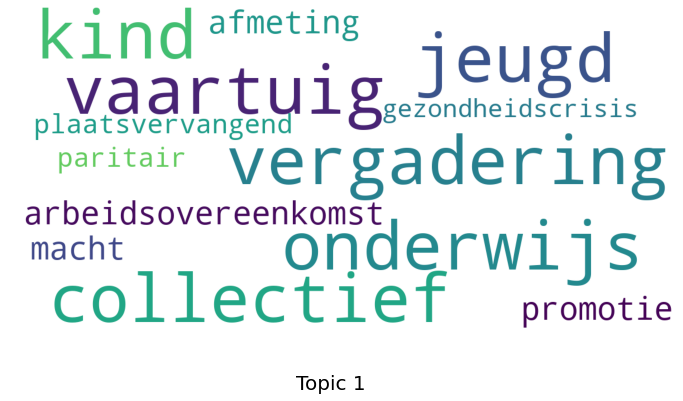

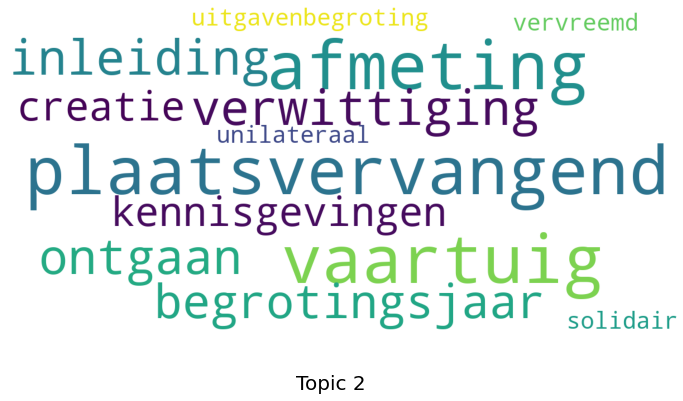

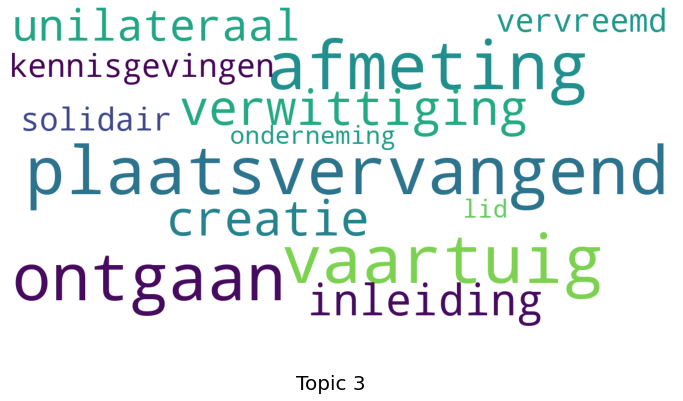

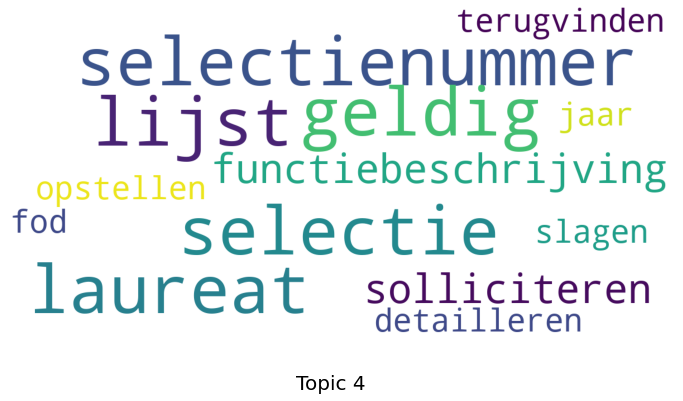

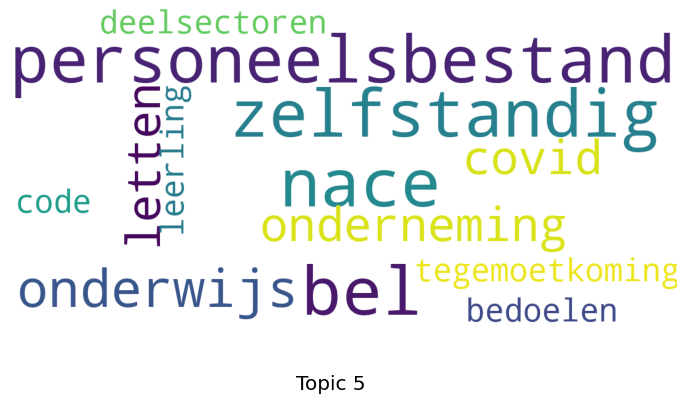

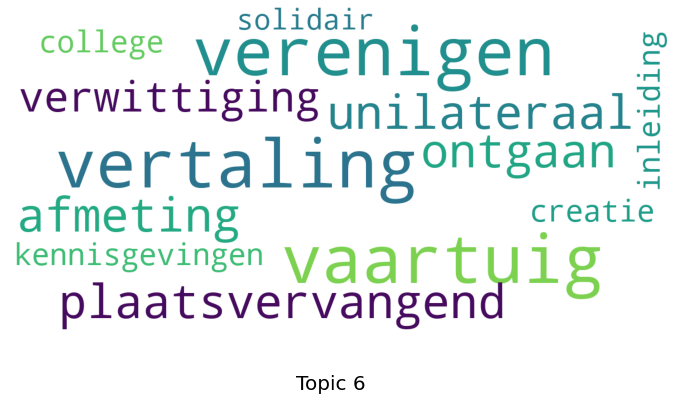

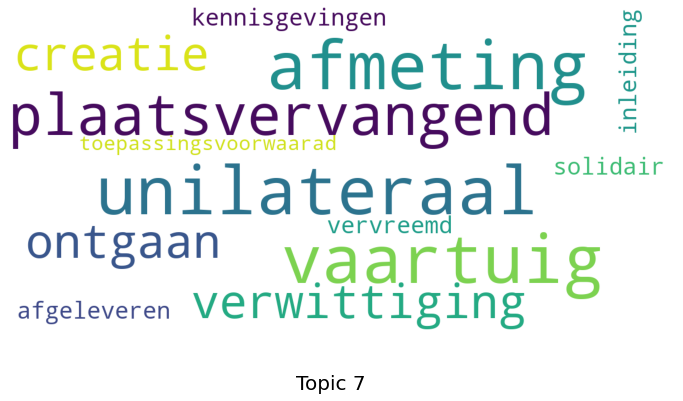

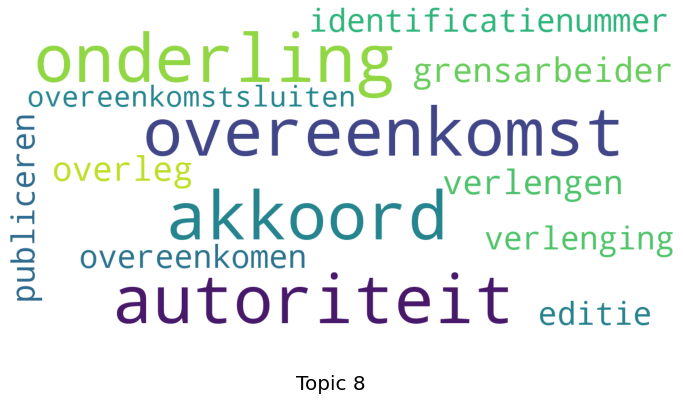

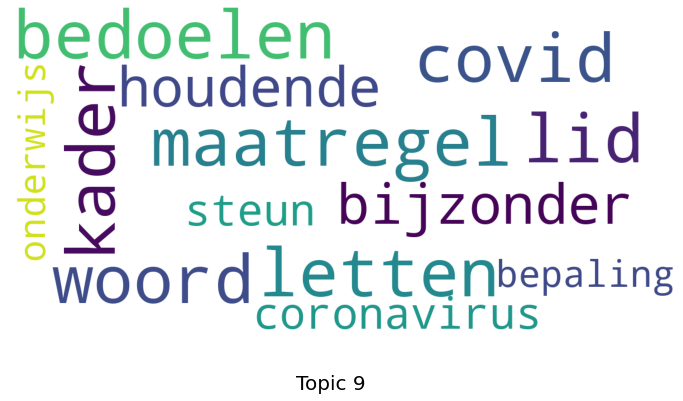

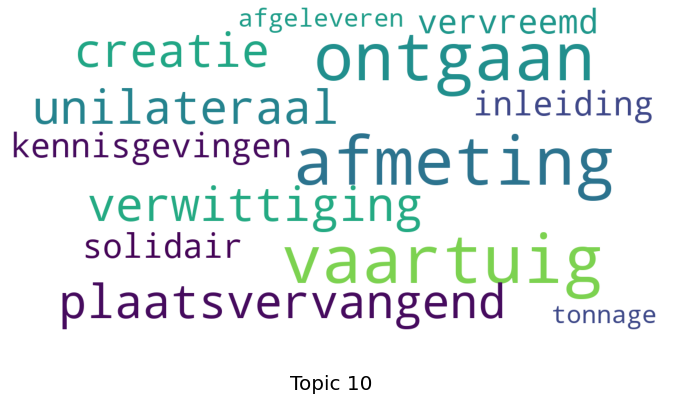

In [41]:
no_top_words = 13
display_topics(lda, tfidf_feature_names, no_top_words)